# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico I : Análisis de features de audio

**Antes de empezar:**
- [Instalar spaCy y el modelo de lenguaje con el que van a trabajar](https://spacy.io/models#quickstart)

**Consideraciones:**
- Se evalúa el estilo y prolijidad del código.
- Se permite hacer trabajo extra, siempre y cuando las actividades básicas estén resueltas.

### Librerías

In [1]:
!pip3 install spotipy
!pip3 install pandas
!pip3 install spacy
!pip3 install pymusixmatch
!pip3 install nltk
!pip install lyricsgenius
# Agregar las librerías extra que se utilicen en esta celda y la siguiente

### Dependencias y acceso al API

In [2]:
import pandas as pd
import numpy as np
import spotipy
import spacy
from spotipy.oauth2 import SpotifyClientCredentials
from musixmatch import Musixmatch
import lyricsgenius

#nlp = spacy.load("en_core_web_sm") #completar con el modelo que van a utilizar

#musixmatch = Musixmatch('1aa5272f4402bf2f082ad2f3958c2c62')

### 1) Plantear una pregunta que quieran responder con estos datos

Las preguntas pueden ser por ejemplo: 
- ¿Por qué este artista destaca dentro de su género?
- ¿Por qué no lo hace?
- ¿Por qué un género musical es más escuchado que otro?

Sin embargo, pueden usar cualquier afirmación que hayan leído en internet y que se pueda responder con los datos este trabajo para validarla o rechazarla.

## Respuesta
**Andres Calamaro** es un cantautor, músico, compositor y productor discográfico argentino. Es considerado como un icono dentro del género del Rock Argentino. **Andres Calamaro**, ganador premios internacionales, va ser objeto de estudio en este trabajo. Se recolectara información del cantante con el objetivo de poder responder las siguientes preguntas:
  * ¿Por que Andres Calamaro destaca dentro de su género, rock argentino y latino?
  * ¿Que diferencia o similitudes tienen los temas musicales con otros cantantes destacados del mismo genero? Tales como Fito Paez, Bersuit Vergarabat, Divididos, Los Abuelos de la Nada


### Carga de dataset


In [3]:
import os.path
from os import path
import string
import re
import numpy as np 
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')

import spacy  
spacy_nlp = spacy.load("es_core_news_sm")   

csv_folder_path = './TP_2_CSV_Files/{}'
genius_token = "upzErEoYU9BAcEOF0WUIQ-Rw_fxFYrU6QeqVhlHXUEc-7VI1jxZvQNiiTGDigvpk"
andres_calamaro_id = "3tAICgiSR5PfYY4B8qsoAU"
andres_calamaro_name= "Andrés Calamaro"
spotify_client_id = "46b333d567314a89a6254b6c6b054be6"
spotify_client_secret = "9d922c3613e441518349dcf55f7d5853"
client_credentials_manager = SpotifyClientCredentials(client_id=spotify_client_id, client_secret=spotify_client_secret)

spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
genius = lyricsgenius.Genius("upzErEoYU9BAcEOF0WUIQ-Rw_fxFYrU6QeqVhlHXUEc-7VI1jxZvQNiiTGDigvpk")


def getLyricsFromGeniusToCSV(file_name, artist_name, max_songs=5, sort='popularity', col_sep_csv = ','):
    if not path.exists(file_name):        
        artist = genius.search_artist(artist_name, max_songs=max_songs, sort= sort)
        songs_dict = {'track_name':[], 'artist_name':[], 'lyrics': []}
        for song in artist.songs:    
            songs_dict['track_name'].append(song.title)    
            songs_dict['artist_name'].append(song.artist)
            songs_dict['lyrics'].append(song.lyrics)
            
        data_frame = pd.DataFrame(songs_dict)
        data_frame.to_csv(file_name,  encoding='utf-8', index=False, sep= col_sep_csv)
    else:
        error_message = 'The file {} already exist.'
        raise Exception(error_message.format(file_name))
        
def getdfRelatedArtistFromSpotify(artist_id, max_artists = 1):
    artists_related = spotify.artist_related_artists(andres_calamaro_id)
    artists_related_list = artists_related['artists']
    artists_dict = {'id':[], 'name':[]}
    artists_range = max_artists if len(artists_related_list) >= max_artists else len(artists_related_list)
    for i in range(artists_range):
        artists_dict['id'].append(artists_related_list[i]['id'])
        artists_dict['name'].append(artists_related_list[i]['name'])
    return pd.DataFrame(artists_dict)

def getLyricsFromArtistsDF(artists_df, max_songs=5, sort='popularity', col_sep_csv = ','):    
    for artist_name in artists_df['name']:
        file_name = artist_name + '_' + str(max_songs) + '.csv'
        try:
            getLyricsFromGeniusToCSV(csv_folder_path.format(file_name), artist_name, max_songs=max_songs, sort=sort, col_sep_csv = col_sep_csv)
        except Exception as err:
            print('Handling exception: ', err)

def getDFJoingArtistFiles(artists_df, suffix='', extension='csv', folder_path='./', sep = ','):
    file_name = '{}{}.{}'
    data_frame = None
    for artist_name in artists_df['name']:
        if data_frame is not None:
            path = folder_path + file_name.format(artist_name, suffix, extension)
            df = pd.read_csv(path , sep=sep)
            data_frame = data_frame.append(df)
        else:
            path = folder_path + file_name.format(artist_name, suffix, extension)            
            data_frame = pd.read_csv(path, sep=sep)
    data_frame.reset_index()
    return data_frame
        
def remove_punctuation(txt):
    text = str(txt)
    spanish_punctuation = string.punctuation + '¿¡'
    txt_no_puntuation = "".join([ c.lower() for c in text if c not in spanish_punctuation])
    return txt_no_puntuation

def tokenizar_spicy(txt):
    return spacy_nlp(txt)

def remove_stopwords_spicy(tokenize_data, language='spanish'):
    stopwords = nltk.corpus.stopwords.words(language)
    return [word for word in tokenize_data if word.text not in stopwords]

def lemmatization_spicy(tokenize_data):
     return [word.lemma_ for word in tokenize_data if word.text.strip() not in '']

def getMostCommonsBigramsArtist(data_frame, artist_name, max_top = 10):
    df = data_frame[data_frame['artista'] == artist_name]
    df = df[['artista','letra']]
    group_by_df = df.groupby(['artista'], as_index = False).agg({'letra': 'sum' }).reset_index()   
    row = group_by_df.iloc[[0]]  
    bigrams = nltk.bigrams(row['letra'].values[0])
    brigrams_count = Counter(bigrams)    
    df_bigram = pd.DataFrame(brigrams_count.most_common(max_top), columns=['Bigrams','Frecuency'])
    return df_bigram
                           
def getMostCommonsUnigramsArtist(data_frame, artist_name, max_top = 10):
    df = data_frame[data_frame['artista'] == artist_name]
    df = df[['artista','letra']]
    group_by_df = df.groupby(['artista'], as_index = False).agg({'letra': 'sum' }).reset_index()   
    row = group_by_df.iloc[[0]]  
    unigrams = nltk.ngrams(row['letra'].values[0],1)
    unigrams_count = Counter(unigrams)    
    df_unigram = pd.DataFrame(unigrams_count.most_common(max_top), columns=['Unigrams','Frecuency'])
    return df_unigram
                       



[nltk_data] Downloading package stopwords to C:\Users\Data
[nltk_data]     Science\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Data
[nltk_data]     Science\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
calamaro_file_name =  andres_calamaro_name + '_100.csv'
try:
    getLyricsFromGeniusToCSV(file_name=csv_folder_path.format(calamaro_file_name),  max_songs=100, artist_name = andres_calamaro_name, col_sep_csv = '#')
except Exception as err:
    print('Handling exception: ', err)

Handling exception:  The file ./TP_2_CSV_Files/Andrés Calamaro_100.csv already exist.


In [5]:
related_artists = getdfRelatedArtistFromSpotify(andres_calamaro_id, max_artists = 20 )
getLyricsFromArtistsDF(related_artists, max_songs=100, col_sep_csv = '#')

Handling exception:  The file ./TP_2_CSV_Files/Fabiana Cantilo_100.csv already exist.
Handling exception:  The file ./TP_2_CSV_Files/Los Rodriguez_100.csv already exist.
Handling exception:  The file ./TP_2_CSV_Files/Fito Paez_100.csv already exist.
Handling exception:  The file ./TP_2_CSV_Files/Los Tipitos_100.csv already exist.
Handling exception:  The file ./TP_2_CSV_Files/Charly García_100.csv already exist.
Handling exception:  The file ./TP_2_CSV_Files/Estelares_100.csv already exist.
Handling exception:  The file ./TP_2_CSV_Files/Bersuit Vergarabat_100.csv already exist.
Handling exception:  The file ./TP_2_CSV_Files/Catupecu Machu_100.csv already exist.
Handling exception:  The file ./TP_2_CSV_Files/Mancha De Rolando_100.csv already exist.
Handling exception:  The file ./TP_2_CSV_Files/Turf_100.csv already exist.
Handling exception:  The file ./TP_2_CSV_Files/Memphis La Blusera_100.csv already exist.
Handling exception:  The file ./TP_2_CSV_Files/Los Caballeros De La Quema_100.

In [6]:
andres_calamaro_path = csv_folder_path.format(calamaro_file_name)
df_andres_calamaro = pd.read_csv(andres_calamaro_path, sep='#')
df_andres_calamaro


,track_name,artist_name,lyrics
0,Flaca,Andrés Calamaro,"[Letra de ""Flaca""]\n\n[Coro]\nFlaca, no me cla..."
1,Mil horas,Andrés Calamaro,Hace frío y estoy lejos de casa\nHace tiempo q...
2,La parte de adelante,Andrés Calamaro,"[Letra de ""La parte de adelante""]\n\nSoy vulne..."
3,Loco,Andrés Calamaro,"[Letra de ""Loco""]\n\n[Verso]\nVoy a salir a ca..."
4,Crímenes Perfectos,Andrés Calamaro,"[Letra de ""Crímenes Perfectos""]\n\nSentiste al..."
...,...,...,...
95,Obsesion - con Diego El Cigala,Andrés Calamaro,Por alto esté el cielo en el mundo\nPor hondo ...
96,No son horas,Andrés Calamaro,"Si te dicen que caí\nY es verdad, y es es verd..."
97,Voy a perder la cabeza por tu amor,Andrés Calamaro,Voy a perder la cabeza por tu amor\nPorque tú ...
98,Señal que te he perdido,Andrés Calamaro,Abro la puerta\nComo un poeta fértil\nDándose ...


In [7]:
df_related_artists = getDFJoingArtistFiles(artists_df=related_artists, suffix='_100', extension='csv', folder_path=csv_folder_path.format(''), sep='#')
df_related_artists

,track_name,artist_name,lyrics
0,Mi Enfermedad,Fabiana Cantilo,"[Letra de ""Mi Enfermedad""]\n\n[Estribillo]\nEs..."
1,Fue Amor,Fabiana Cantilo,"[Letra de ""Fue Amor""]\n\n[Verso 1]\nYo podría ..."
2,Nada Es Para Siempre,Fabiana Cantilo,"[Letra de ""Nada Es Para Siempre""]\n\n[Verso 1]..."
3,Amanece En La Ruta,Fabiana Cantilo,"[Letra de ""Amanece en la Ruta""]\n\nAmanece en ..."
4,Mary Poppins y el Deshollinador,Fabiana Cantilo,"[Letra de ""Mary Poppins y el Deshollinador""]\n..."
...,...,...,...
95,Cosas De Baboon,Divididos,Si queres saber\nDonde clava el escorpión\nSi ...
96,Puertas,Divididos,Que puertas abrir\nQue puertas cerrar\nQue pue...
97,Sopa de tortuga,Divididos,Comencé a entender cuando escuche\nEsta oferta...
98,Libre El Jabalí,Divididos,Con la pilcha equivocada me estrellé\nCaí redo...


### 2) Obtener datos para responder la pregunta

Para extraer las letras de las canciones usaremos la [API de MusiXmatch](https://developer.musixmatch.com/documentation) a través de su [wrapper en Python](https://github.com/hudsonbrendon/python-musixmatch).
Una vez obtenidas las letras de las canciones, las procesaremos de la siguiente manera:
1. Tokenizar
2. Remover las [stop-words](https://es.wikipedia.org/wiki/Palabra_vac%C3%ADa)
3. [Lema](https://es.wikipedia.org/wiki/Lema_(ling%C3%BC%C3%ADstica))tizar las palabras que hayan quedado
4. Organizar todo en un DataFrame de la forma Canción-Artista-Letra donde Letra es el resultado de 3.

**Recomendación** : Usar un dataframe para su artista y otro para la competencia si es que eligierone esa opción, les va a ahorrar tiempo.

**Aclaración** : Si plantearon una pregunta que no requiera los datos de la consigna, obtengan esos datos.

In [8]:
df_andres_calamaro['letra'] = df_andres_calamaro['lyrics'].apply(lambda x: lemmatization_spicy(remove_stopwords_spicy(tokenizar_spicy(remove_punctuation(x)))))
df_andres_calamaro.columns = ['cancion','artista','lyrics','letra']
df_npl_andres_calamaro = df_andres_calamaro[['cancion','artista', 'letra']]
df_npl_andres_calamaro

,cancion,artista,letra
0,Flaca,Andrés Calamaro,"[letra, flaco, coro, flaco, clave, puñal, espa..."
1,Mil horas,Andrés Calamaro,"[hacer, freír, lejos, casar, hacer, tiempo, se..."
2,La parte de adelante,Andrés Calamaro,"[letra, partir, adelantar, vulnerable, lado, a..."
3,Loco,Andrés Calamaro,"[letra, loco, versar, ir, salir, caminar, soli..."
4,Crímenes Perfectos,Andrés Calamaro,"[letra, crimen, perfecto, sentir, alguno, vez,..."
...,...,...,...
95,Obsesion - con Diego El Cigala,Andrés Calamaro,"[alto, cielo, mundo, hondo, mar, profundar, ba..."
96,No son horas,Andrés Calamaro,"[si, decir, caer, verdad, verdad, sentir, segu..."
97,Voy a perder la cabeza por tu amor,Andrés Calamaro,"[ir, perder, cabeza, amor, aguar, fuego, compr..."
98,Señal que te he perdido,Andrés Calamaro,"[abrir, puerta, poeta, fértil, dándose, conoce..."


In [9]:
df_related_artists['letra'] = df_related_artists['lyrics'].apply(lambda x: lemmatization_spicy((remove_stopwords_spicy(tokenizar_spicy(remove_punctuation(x))))))
df_related_artists.columns = ['cancion','artista','lyrics','letra']
df_npl_competencia = df_related_artists[['cancion','artista', 'letra']]
df_npl_competencia

,cancion,artista,letra
0,Mi Enfermedad,Fabiana Cantilo,"[letra, enfermedad, estribillo, vencer, mundo,..."
1,Fue Amor,Fabiana Cantilo,"[letra, amor, versar, 1, poder, haberlo, hacer..."
2,Nada Es Para Siempre,Fabiana Cantilo,"[letra, siempre, versar, 1, querer, lastimar, ..."
3,Amanece En La Ruta,Fabiana Cantilo,"[letra, amanecer, ruta, amanecer, ruta, import..."
4,Mary Poppins y el Deshollinador,Fabiana Cantilo,"[letra, mary, poppins, deshollinador, estribil..."
...,...,...,...
95,Cosas De Baboon,Divididos,"[si, queres, saber, clavar, escorpión, si, que..."
96,Puertas,Divididos,"[puerta, abrir, puerta, cerrar, puerta, abrir,..."
97,Sopa de tortuga,Divididos,"[comenzar, entender, escuchar, ofertar, podar,..."
98,Libre El Jabalí,Divididos,"[pilcha, equivocar, estrellar, caer, redondo, ..."


In [10]:
print(f'Andres Calamar Shape {df_npl_andres_calamaro.shape} ; Competencia Shape {df_npl_competencia.shape}')

Andres Calamar Shape (100, 3) ; Competencia Shape (1512, 3)


### 3) Encontrar los n-gramas (n= 1, 2) más comunes y usarlos en gráficos.
Utilizando las librerías de la celda de abajo obtendremos los conjuntos de 1 y 2 palabras más comunes para cada artista con el que trabajaremos. Luego usaremos los unigramas para graficar una [word-cloud](https://i.imgur.com/8I8aJ1N.png) y un gráfico de distribución de frecuencia para unigramas y bigramas por autor (o de la forma que se adapte a su pregunta).

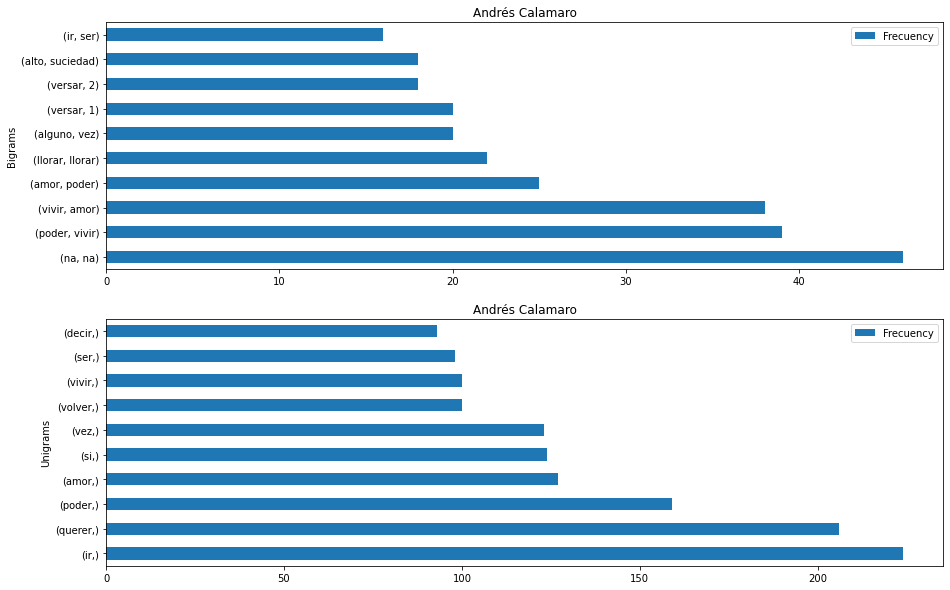

In [11]:
figure, axes = plt.subplots(2,1, figsize=(15,10))

df_bigram = getMostCommonsBigramsArtist(df_npl_andres_calamaro, andres_calamaro_name, 10)
df_bigram.plot.barh(x='Bigrams', y='Frecuency', rot=0, title = andres_calamaro_name,  ax=axes[0])

df_bigram = getMostCommonsUnigramsArtist(df_npl_andres_calamaro, andres_calamaro_name, 10)
df_bigram.plot.barh(x='Unigrams', y='Frecuency', rot=0, title = andres_calamaro_name,  ax=axes[1])

In [12]:
df_npl_competencia['artista'].unique()

array(['Fabiana Cantilo', 'Los Rodríguez', 'Fito Páez', 'Los Tipitos',
       'Charly García', 'Estelares', 'Bersuit Vergarabat',
       'Catupecu Machu', 'Mancha De Rolando', 'Turf',
       'Memphis La Blusera', 'Los Caballeros De La Quema',
       'Los Abuelos De La Nada', 'Serú Girán', 'Los Piojos', 'Vicentico',
       'La Portuaria', 'Ratones Paranoicos', 'Intoxicados', 'Divididos'],
      dtype=object)

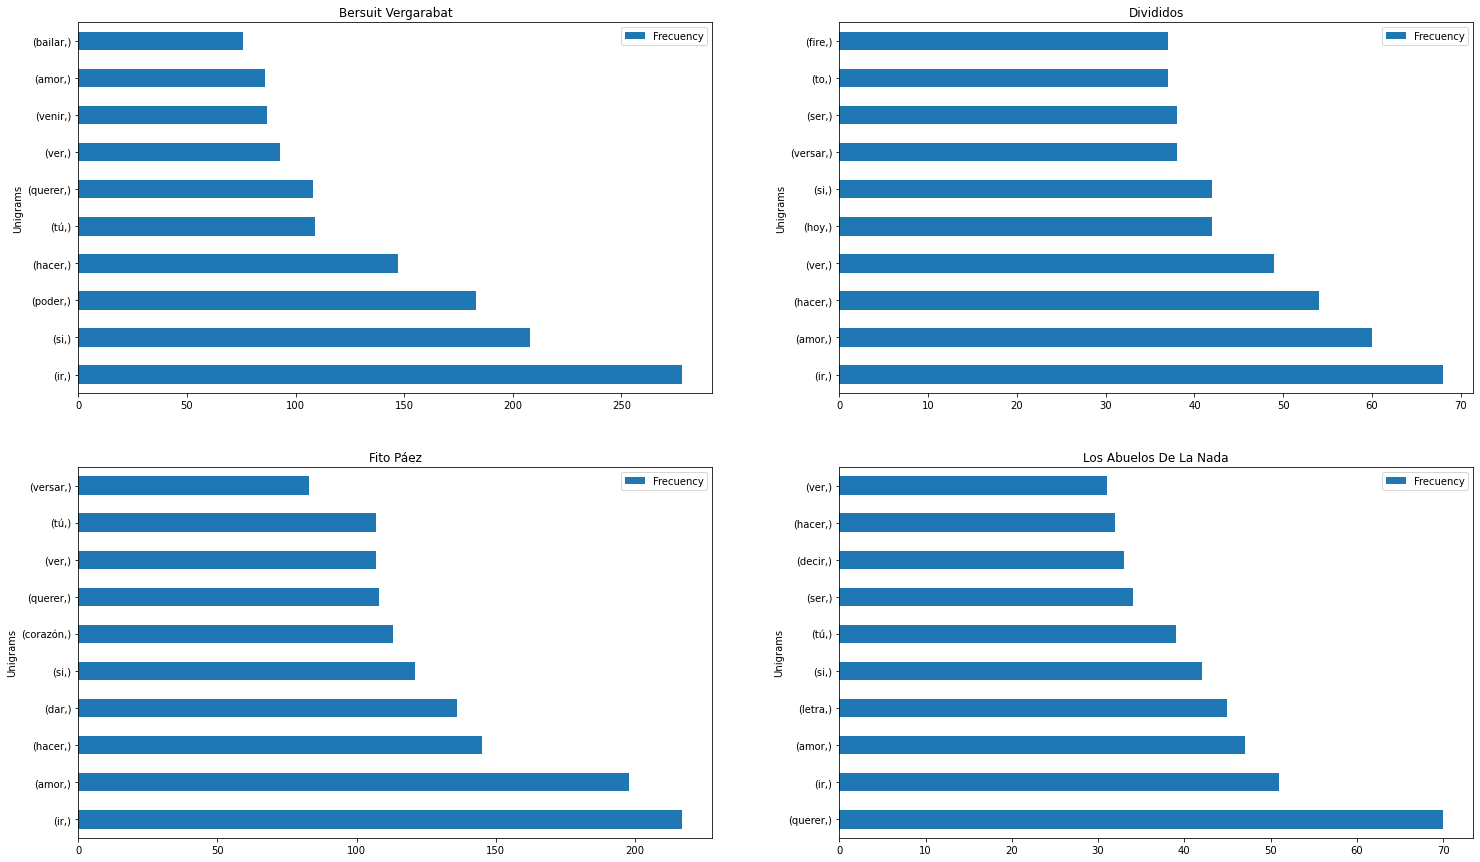

In [13]:
bersuit_vergarabat_name = 'Bersuit Vergarabat'
divididos_name = 'Divididos'
fito_paez_name = 'Fito Páez'
los_abuelos_de_la_nada_name = 'Los Abuelos De La Nada'


figure, axes = plt.subplots(2,2, figsize=(25,15))

df_bigram = getMostCommonsUnigramsArtist(df_npl_competencia, bersuit_vergarabat_name, 10)
df_bigram.plot.barh(x='Unigrams', y='Frecuency', rot=0, title = bersuit_vergarabat_name, ax=axes[0,0])

df_bigram = getMostCommonsUnigramsArtist(df_npl_competencia, divididos_name, 10)
df_bigram.plot.barh(x='Unigrams', y='Frecuency', rot=0, title = divididos_name, ax=axes[0,1])

df_bigram = getMostCommonsUnigramsArtist(df_npl_competencia, fito_paez_name, 10)
df_bigram.plot.barh(x='Unigrams', y='Frecuency', rot=0, title = fito_paez_name, ax=axes[1,0])

df_bigram = getMostCommonsUnigramsArtist(df_npl_competencia, los_abuelos_de_la_nada_name, 10)
df_bigram.plot.barh(x='Unigrams', y='Frecuency', rot=0, title = los_abuelos_de_la_nada_name, ax=axes[1,1])

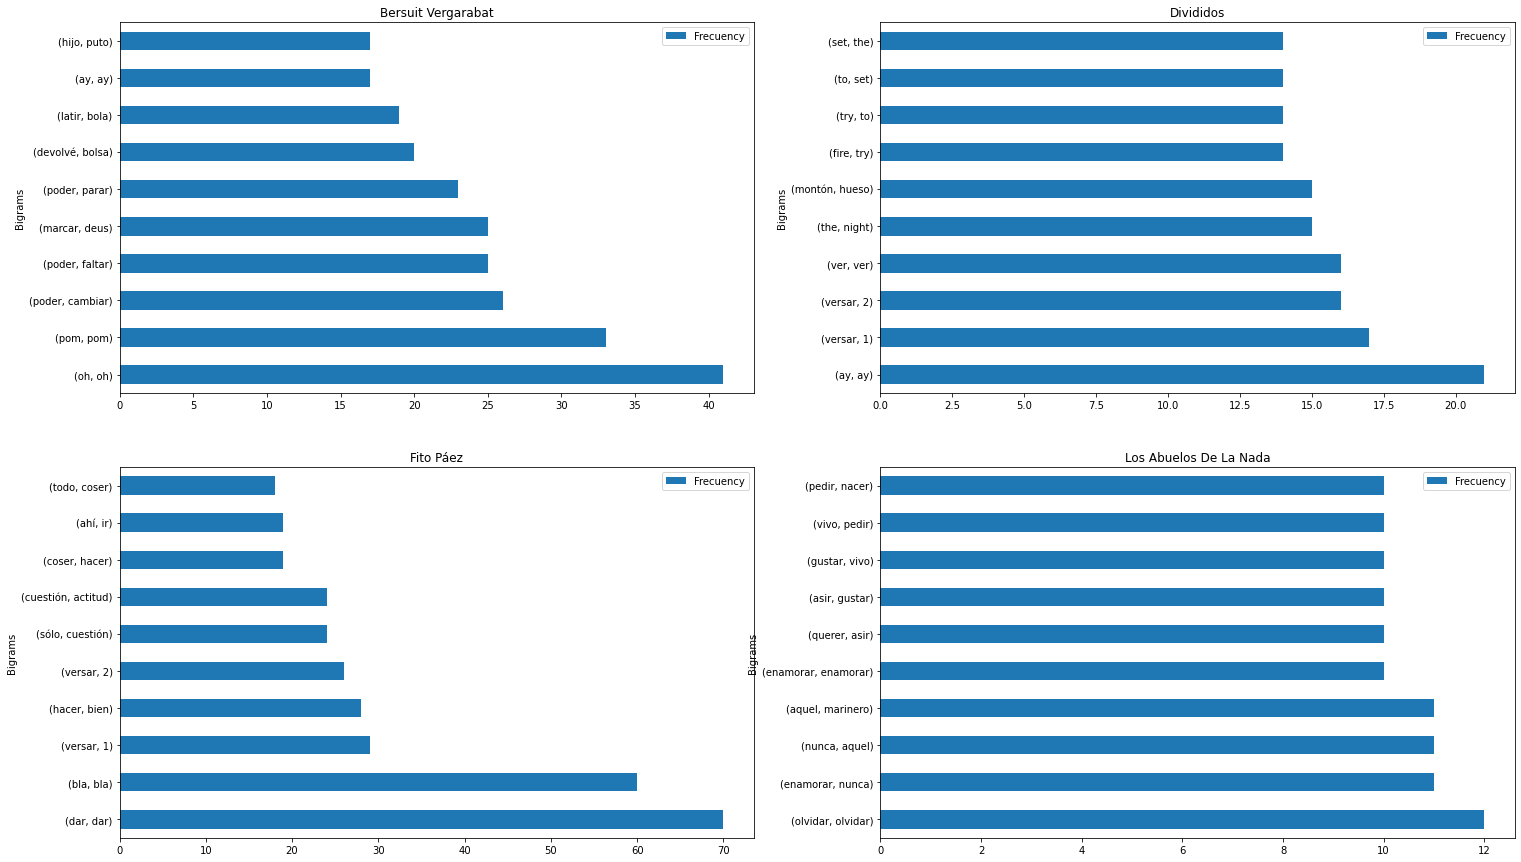

In [14]:
figure, axes = plt.subplots(2,2, figsize=(25,15))

df_bigram = getMostCommonsBigramsArtist(df_npl_competencia, bersuit_vergarabat_name, 10)
df_bigram.plot.barh(x='Bigrams', y='Frecuency', rot=0, title = bersuit_vergarabat_name, ax=axes[0,0])

df_bigram = getMostCommonsBigramsArtist(df_npl_competencia, divididos_name, 10)
df_bigram.plot.barh(x='Bigrams', y='Frecuency', rot=0, title = divididos_name, ax=axes[0,1])

df_bigram = getMostCommonsBigramsArtist(df_npl_competencia, fito_paez_name, 10)
df_bigram.plot.barh(x='Bigrams', y='Frecuency', rot=0, title = fito_paez_name, ax=axes[1,0])

df_bigram = getMostCommonsBigramsArtist(df_npl_competencia, los_abuelos_de_la_nada_name, 10)
df_bigram.plot.barh(x='Bigrams', y='Frecuency', rot=0, title = los_abuelos_de_la_nada_name, ax=axes[1,1])



### 4) Escribir un informe

Este informe tiene que describir qué datos que obtuvieron, el volumen de estos (# de canciones del artista, # de canciones de la competencia, etc), una explicación de cómo estos se relacionan con la pregunta planteada, cómo ayudan a responderla y los resultados que obtuvieron. Usar la celda de abajo con formato markdown.

En este trabajo, el volumen de datos fue obtenido mediante spotify y genius. 
Se analizaron las canciones de diferentes artistas relacionados con el artista principal bajo estudio, el cuál es Andres Calamaro. 
Andres Calamaro es un cantante destacado junto con otros en su genero musical. Se busco responder, mediante el análisis de sus canciones, las siguientes respuestas: 
  * ¿Por que Andres Calamaro destaca dentro de su género, rock argentino y latino?
  * ¿Que diferencia o similitudes tienen los temas musicales con otros cantantes destacados del mismo genero? Tales como Fito Paez, Bersuit Vergarabat, Divididos, Los Abuelos de la Nada
  
Para ello se pudieron recolectar un promedio de 100 temas musicales por artista.
Como resultado de este trabajo se pude observar que estos artistas tienen muchas similitudes en sus temas, que posiblemente hacen que destaquen tanto.
Andes Calamaro interpreta temas musicales con un foco centrado en la vida, el amor, sociedad;  la emociones son el centro de sus temas. A ellos se le suma verbos como ir, querer, poder. Se puede concluir que sus temas tiene fuerte relación esa a poder amar, vivir, ser e irse en nuestra actualidad.
Sorprendementes se encontro el mismo patrón con el resto de los cantantes (Divididos, Fito Paez, Los Abuelos de la Nada y Bersuit Vergarabat). El amor y la vida son el centro de estos cantantes. Sin embargo se pueden observar unas pequeñas sutilezas en cada cantante:
  * Bersuit Vergarabat: sus canciones hablan de "poder cambiar, poder parar, ir, venir"
  * Divididos: sus canciones se relaciona más al amor, irse, hacer.
  * Paez: Al igual que los otros cantante, sus temas hablan de irse, amar, querer.
  * Los Abuelos de la Nada: Su teman hacen refencia a enarmorar, olvidar, querer e irse
La carrera y exito de Andres Calamaro y su "compentencia" son indiscutibles, hay más similitudes que diferencias en sus temas. No es fácil determinar que hace que este cantante destaque sobre los otros, sin embargo, este análisis junto con un análisis de su musica e interpretación no pueden dar mayor información para alcanzar un buena respuesta.